# SageMaker Inference with mmdetection3D

This notebook will use the model you trained earlier in the workshop to perform inference using [mmdetection3D](https://github.com/open-mmlab/mmdetection3d).

Point cloud data can be rather large. Because the input to the inference function may be quite large, we will use SageMaker's [Asynchronous Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference.html) capability.

The notebook will follow these basic steps:

* Define a SageMaker model using the results from our training process
* Create an async inference endpoint
* Test the endpoint

## Async Inference

SageMaker real-time inference endpoints typically act in a synchronous mode, just like any RESTful API.  That poses a challenge for cases where the input or output are too large for a normal REST payload.  SageMaker async inference endpoints solve that problem.

![Async Inference](display_images/async-inf.png)

_Image copied from a [SageMaker example notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/async-inference/Async-Inference-Walkthrough.ipynb)_

When a request comes in to an async inference endpoint, the request goes into an internal queue, and references input data stored in an S3 bucket.  When the inference code runs, it gets the input data from S3 and gets the inference.  SageMaker stores the result in another S3 object, which we can download later.

See this [example notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/async-inference/Async-Inference-Walkthrough.ipynb) for a more detailed walkthrough of async inference endpoints.

### Inference I/O format

Since we are providing our own inference code, we can determine the input and output formats.  The input to the inference endpoint is a point cloud from A2D2.  The response is a [pickled](https://docs.python.org/3/library/pickle.html) version of the mmdetect response object.

The model artifact has to contain a configuration file and a model checkpoint.  The configuration file 
can point to other items in the `mmdetection3d` folder, but it has to contain absolute paths.  In the image,
`mmdetection3d` is installed directly under the root.

We have the mmdetect configuration file and model checkpoint prepared from the previous notebook.

### Inference code

Our inference container runs a [Flask](https://flask.palletsprojects.com/en/2.0.x/) server to respond to inference requests.  You can review the code in the `container_inference` directory.  The files `serve`, `nginx.conf`, and `wsgi.py` are boilerplate for the Flask server.  

The interesting code is in `predictor.py`.

In [13]:
!pygmentize -l python container_inference/mm3d/predictor.py

# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.

from __future__ import print_function

import os
import io
import json
import tempfile
import pickle

import flask

import torch

from mmdet3d.apis import init_model, inference_detector

prefix = '/opt/ml/'
model_path = os.path.join(prefix, 'model')

# A singleton for holding the model. This simply loads the model and holds it.
# It has a predict function that does a prediction based on the model and the input data.

"""
The model artifact must contain the configuration file and the model checkpoint.

The configuration file should contain absolute paths to /mmdetection3d if it points
to base files.

The prediction method accepts a point cloud byte stream, and returns a pickled version
of the response.
"""

class PredictService(object):
    model = None                # Where we keep the model when it's loaded

    @classmethod
    def get_model(cls):
        """Get the model object for this instance, loading it if it

You'll notice that the `predictor.py` code handles two Flask methods.  The first, `ping`, is just a health check that lets SageMaker know that the endpoint is ready to serve.  In that method, we see if we can load the model successfully.

The second method, `transformation`, actually returns an inference.  

### Install pytransform3d

We will install pytransform3d that we will use later to visualize our inference results.

In [ ]:
!pip install pytransform3d

## Upload model artifact

When you train a model in SageMaker it packages the results in a compressed `model.tar.gz` file. This file contains the trained model weights and any model configuration files. SageMaker inference requires your model to be in this format, but since we trained our model in SageMaker it's already in the correct format. Let's upload this file to S3 so our endpoint can retrieve it later.

In [3]:
# Use the default notebook execution role
from sagemaker import get_execution_role

role = get_execution_role()

In [ ]:
from sagemaker.s3 import S3Uploader
import sagemaker
import boto3

# Upload model artifact to S3
file_key = 'model.tar.gz'
sm_session = sagemaker.session.Session()
bucket = sm_session.default_bucket()
prefix = "mm3d"
b3sess = boto3.Session()
region = b3sess.region_name
model_artifact = S3Uploader.upload(file_key, f's3://{bucket}/{prefix}/model')
print(model_artifact)

### Deployment container

If running this in an AWS instructor led workshop, your container may have already been built ahead of time, but if running this on your own, you'll need to build your deployment container.

SageMaker inference supplies a variety of different built in inference containers, since `mmdetection3d` is a library with its own set of complex dependencies, we are going to use a custom hosting container. This process will take ~10 minutes.

In [ ]:
IMAGE_NAME = 'mm3dinf'

# logging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin 763104351884.dkr.ecr.{region}.amazonaws.com
!bash ./build_and_push.sh {region} {IMAGE_NAME} latest container_inference 

In [16]:
import time
account = boto3.client('sts').get_caller_identity()['Account']

container = f'{account}.dkr.ecr.us-east-1.amazonaws.com/{IMAGE_NAME}'
model_name = f'sagemaker-mm3d-{int(time.time())}'
print(container)
print(model_name)

427894311213.dkr.ecr.us-east-1.amazonaws.com/mm3dinf
sagemaker-mm3d-1637716167


### Create SageMaker model

Before we deploy our endpoint, we need to create a SageMaker model. A SageMaker model is different from the model we trained in the previous notebook in that it contains the information necessary to create the environment around the model so that it can be deployed as an endpoint when paired with an endpoint configuration, which will tell SageMaker what kind of instance to deploy the model to. 

In [17]:
# Define SageMaker model using our container and model artifact

import boto3
sm_client = boto3.client("sagemaker")

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', 
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

In [18]:
# Confirm that the model was created
create_model_response

{'ModelArn': 'arn:aws:sagemaker:us-east-1:427894311213:model/sagemaker-mm3d-1637716167',
 'ResponseMetadata': {'RequestId': '939ba444-4dd8-4067-bfc6-93e86759a92c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '939ba444-4dd8-4067-bfc6-93e86759a92c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '87',
   'date': 'Wed, 24 Nov 2021 01:09:28 GMT'},
  'RetryAttempts': 0}}

## Create inference endpoint

In this section, we'll create an async inference endpoint. We take the model object we created previously and pair it with an endpoint configuration that tell SageMaker how many and what type of instances to deploy the model to. In this case we also use the endpoint configuration to tell SageMaker we want to make this endpoint an asynchronous endpoint.  

In [19]:
# Define an endpoint that uses one ml.g4dn.2xlarge instance and uses async inference
from time import strftime,gmtime
endpoint_config_name = f"MM3DAsyncEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.2xlarge",
            "InitialInstanceCount": 1
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{prefix}/output"
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 1
        }
    }
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-east-1:427894311213:endpoint-config/mm3dasyncendpointconfig-2021-11-24-01-09-32


Now that we have created our SageMaker model object and our endpoint configuration, we can deploy our endpoint. The deployment process takes 5-10 minutes.

In [20]:
# Deploy the endpoint
endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_response = sm_client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

Creating Endpoint: arn:aws:sagemaker:us-east-1:427894311213:endpoint/sm-2021-11-24-01-09-42


Running the following cell will launch a waiter that will alert us when our endpoint has been successfully deployed.

In [21]:
# Wait for the endpoint to enter service
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


## Test the endpoint

Next we'll upload an A2D2 point cloud file and test the inference endpoint.  Since we're using async inference, the call to the endpoint doesn't return the inference instantaneously.  Rather, it returns a pointer to the S3 output location.  We can check for the presence of the results there.

In [22]:
# Helper method for uploading to S3
def upload_file(input_location, prefix):
    prefix = f"{prefix}/input"
    return sm_session.upload_data(
        input_location, 
        bucket=sm_session.default_bucket(),
        key_prefix=prefix)

First we upload our point cloud file to a location in S3. Let's gather the paths to our scene IDs and pick a scene and a frame.

In [33]:
from glob import glob

scene_ids = sorted(glob('../fsx/a2d2/camera_lidar_semantic_bboxes/2018*'))
scene_ids

['../fsx/a2d2/camera_lidar_semantic_bboxes/20180807_145028',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20180810_142822',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20180925_101535',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20180925_112730',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20180925_124435',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20180925_135056',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181008_095521',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181016_125231',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181107_132300',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181107_132730',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181107_133258',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181108_084007',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181108_091945',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181108_103155',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181108_123750',
 '../fsx/a2d2/camera_lidar_semantic_bboxes/20181204_135952',
 '../fsx/a2d2/camera_lid

In [59]:
dataset_root_path = "../fsx/a2d2/"
scene_id = "20180807_145028"
file_scene_prefix = scene_id.replace("_", "")
frame_id = "000000091"

input_1_location = f"../fsx/a2d2/camera_lidar_semantic_bboxes/{scene_id}/lidar/cam_front_center/{file_scene_prefix}_lidar_frontcenter_{frame_id}.bin"
input_1_s3_location = upload_file(input_1_location, prefix)
print(input_1_s3_location)

s3://sagemaker-us-east-1-427894311213/mm3d/input/20180807145028_lidar_frontcenter_000000091.bin


In [51]:
sm_runtime = boto3.client("sagemaker-runtime")

In [60]:
# Invoke endpoint using boto3 API
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

OutputLocation: s3://sagemaker-us-east-1-427894311213/mm3d/output/638e6b4c-3878-470c-ad82-9c8beb9f9a23.out


In [61]:
# Parse the output S3 location from the response
from urllib.parse import urlparse
parse_object = urlparse(output_location)
parse_object.netloc

'sagemaker-us-east-1-427894311213'

In [62]:
parse_object.path[1:]

'mm3d/output/638e6b4c-3878-470c-ad82-9c8beb9f9a23.out'

In [63]:
# Download the output.  
s3_client = boto3.client('s3')
s3_client.download_file(parse_object.netloc, parse_object.path[1:], 'test.pkl')

In [64]:
# The output is a pickled Python object.  Convert it back to a dictionary.
import pickle
with open('test.pkl', 'rb') as test_f:
    test_out = pickle.load(test_f)

ModuleNotFoundError: No module named 'mmdet3d'

In [ ]:
import pandas as pd
pd.read_pickle('test.pkl', )

In [ ]:
# View the output
test_out

NameError: name 'test_out' is not defined

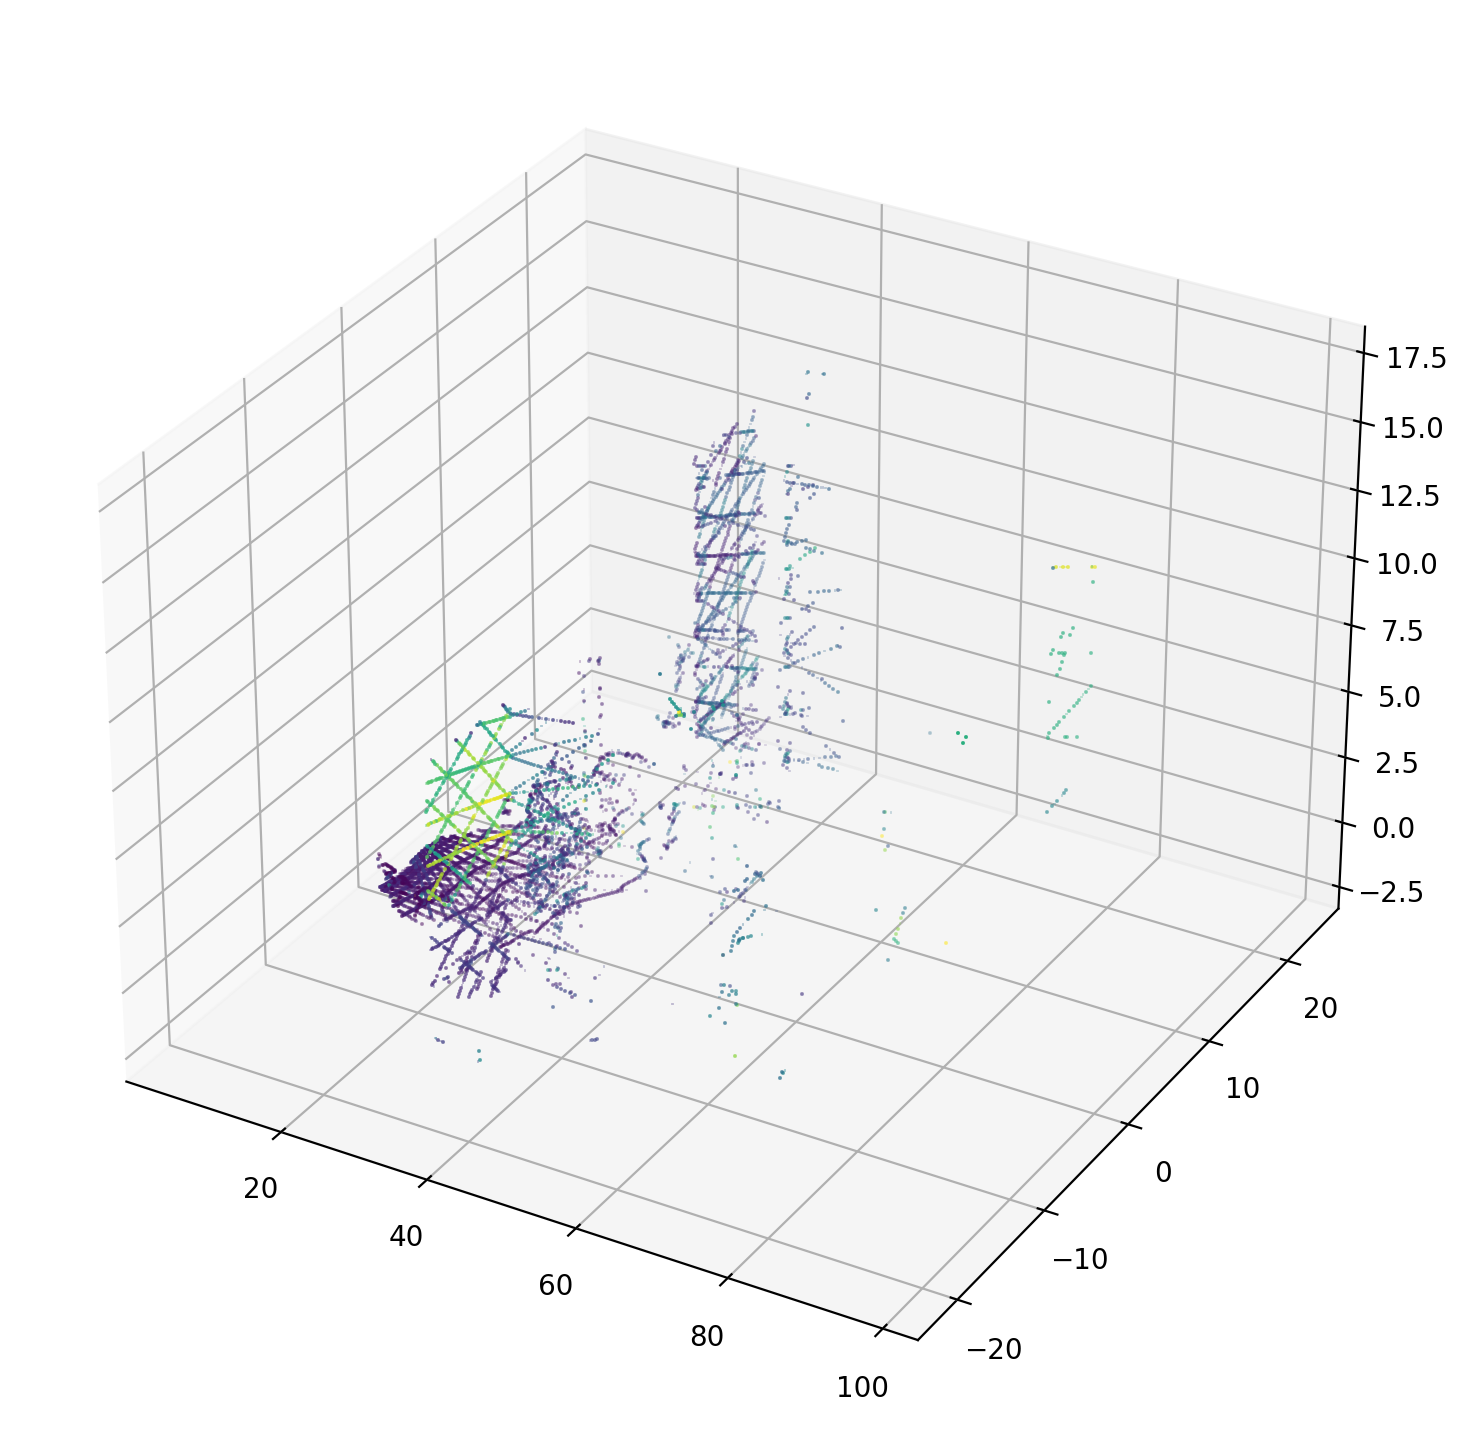

In [65]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pytransform3d import plot_utils
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt

from a2d2_helpers import undistort_image, generate_color_map


file_scene_prefix = scene_id.replace("_", "")
scene_path = Path(dataset_root_path) / "camera_lidar_semantic_bboxes" / scene_id
frame_image_path = scene_path / "camera" / "cam_front_center" / f"{file_scene_prefix}_camera_frontcenter_{frame_id}.png"
frame_lidar_path = scene_path / "lidar" / "cam_front_center" / f"{file_scene_prefix}_lidar_frontcenter_{frame_id}.npz"
frame_label_path = scene_path / "label3D" / "cam_front_center" / f"{file_scene_prefix}_label3D_frontcenter_{frame_id}.json"

# Load our frame point cloud from the compressed NPZ format, grabbing the points and reflectance corresponding
# to those points. We'll use the reflectance to color our points in the 3D plot.
lidar_frame = np.load(str(frame_lidar_path))
points = lidar_frame["points"]
reflectance = lidar_frame["reflectance"]


fig = plt.figure(figsize=(20,10), dpi=200)
ax_3d = fig.add_subplot(1, 2, 1, projection='3d')

# Plot our point cloud.
ax_3d.scatter(points[:,0], points[:,1], points[:,2], s=0.1, c=reflectance, marker=",")

inference_score_pairs = list(zip(test_out["result"][0]["boxes_3d"], test_out["result"][0]["scores_3d"]))
inference_score_pairs = sorted(inference_score_pairs, key=lambda inf_score_pair: -inf_score_pair[1])

for inference, score in inference_score_pairs[:5]:
    x, y, z, l, w, h, yaw = inference
    # See https://mmdetection3d.readthedocs.io/en/latest/api.html for details on mmdetection output format.
    qw, qx, qy, qz = pr.quaternion_from_matrix(pr.matrix_from_axis_angle([0, 0, 1, np.pi / 2 - yaw]))
    A2B = pt.transform_from_pq([x, y, z, qw, qx, qy, qz])
    size = [w, l, h]

    plot_utils.plot_box(ax_3d, size=size, A2B=A2B, alpha=0.4)
    plot_utils.Frame(A2B).add_frame(ax_3d)

# Load our frame image from the file system.
image_frame = cv2.imread(str(frame_image_path))
image_frame = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)


# Show image side by side.
ax_2d = fig.add_subplot(1, 2, 2)
ax_2d.imshow(image_frame)
ax_2d.set_title("Image with projected labels overlayed")


limit_m = 10
translation = [25, 0, 0]
ax_3d.set_xlim((-limit_m + translation[0], limit_m + translation[0]))
ax_3d.set_ylim((-limit_m + translation[1], limit_m + translation[1]))
ax_3d.set_zlim((-limit_m + translation[2], limit_m + translation[2]))
ax_3d.set_xlabel("X")
ax_3d.set_ylabel("Y")
ax_3d.set_zlabel("Z")
ax_3d.view_init(5, 180)

## Local mode testing

If you want to test inference in local mode, you can use this section of the notebook.  You'll need to edit the container URL and the location of the input point cloud file.  Also note that we specify the SHA of the current version of the container image, so that the local mode endpoint knows when we have a new image to test.

In [14]:
# EDIT CONTAINER IMAGE URL AND SHA IN THIS CELL

container = f'{account}.dkr.ecr.us-east-1.amazonaws.com/mm3dinf'
container_sha = 'sha256:fb255d08c7b89798322fb7b59064ff6dfc144076f9fb87052ee006793114af61'
s_model = sagemaker.model.Model(f"{container}@{container_sha}", model_data=model_artifact, role=role, predictor_cls=sagemaker.predictor.Predictor)

In [15]:
# Deploy a new local endpoint
predictor = s_model.deploy(
        initial_instance_count=1,
        instance_type='local_gpu',
        
    )

Attaching to 7cmbmklpdb-algo-1-34joy
7cmbmklpdb-algo-1-34joy | Starting the inference server with 1 workers.
7cmbmklpdb-algo-1-34joy | [2021-09-29 19:24:30 +0000] [10] [INFO] Starting gunicorn 20.1.0
7cmbmklpdb-algo-1-34joy | [2021-09-29 19:24:30 +0000] [10] [INFO] Listening at: unix:/tmp/gunicorn.sock (10)
7cmbmklpdb-algo-1-34joy | [2021-09-29 19:24:30 +0000] [10] [INFO] Using worker: gevent
7cmbmklpdb-algo-1-34joy | [2021-09-29 19:24:30 +0000] [14] [INFO] Booting worker with pid: 14
7cmbmklpdb-algo-1-34joy | Loading config file /opt/ml/model/config.py from path /opt/ml/model
7cmbmklpdb-algo-1-34joy | Use load_from_local loader
!7cmbmklpdb-algo-1-34joy | 172.18.0.1 - - [29/Sep/2021:19:24:47 +0000] "GET /ping HTTP/1.1" 200 1 "-" "python-urllib3/1.26.6"


In [10]:
# EDIT POINT CLOUD LOCATION IN THIS CELL

pcd = '/home/ec2-user/SageMaker/mmdetection3d/demo/data/kitti/kitti_000008.bin'
with open(pcd, 'rb') as in_file:
    d = in_file.read()

In [17]:
# Get prediction locally
r = predictor.predict(d)

7cmbmklpdb-algo-1-34joy | 172.18.0.1 - - [29/Sep/2021:19:25:01 +0000] "POST /invocations HTTP/1.1" 200 273176 "-" "python-urllib3/1.26.6"


In [18]:
# Deserialize the output
import pickle
rr = pickle.loads(r)

In [19]:
rr

{'result': [{'boxes_3d': LiDARInstance3DBoxes(
       tensor([[ 14.6441,  -1.0253,  -1.4654,   1.5818,   3.5405,   1.4238,   1.9014],
           [  8.1068,   1.2317,  -1.5741,   1.5685,   3.6499,   1.5669,  -1.2676],
           [  6.4485,  -3.9033,  -1.7702,   1.4480,   3.1376,   1.4134,   1.8713],
           [ 33.6312,  -7.0466,  -1.2669,   1.7493,   4.2478,   1.7997,  -1.3286],
           [ 20.3409,  -8.5007,  -1.7535,   1.5314,   2.9346,   1.5897,   1.9065],
           [  3.6581,   2.7923,  -1.5880,   1.6003,   3.7974,   1.5032,   1.8749],
           [ 28.6658,  -1.6604,  -0.9765,   1.5613,   3.6019,   1.4319,  -2.8361],
           [ 24.9876, -10.1824,  -1.7463,   1.6124,   3.6524,   1.5026,   1.9261],
           [ 55.4273, -20.2328,  -1.2698,   1.6636,   4.0447,   1.5492,  -1.2440],
           [ 40.9541,  -9.7344,  -1.2866,   1.6136,   3.7349,   1.5464,   1.9563],
           [ 52.4317, -21.8914,  -1.0279,   1.5377,   3.4696,   1.5046,  -1.2648]])),
   'scores_3d': tensor([0.9443, 0

## Cleanup

Make sure to delete unused endpoints, especially if you are running this in your own account!

In [ ]:
response = sm_client.delete_endpoint(
    EndpointName=endpoint_name
)
response

## Conclusion

You've now learned how to use Amazon SageMaker for end to end 3D machine learning! We hope you enjoyed this workshop, now it's your turn to apply what you've learned here to your own machine learning workflows!